# **This is for the Playground Prediction Competition** "Playground Series - Season 3, Episode 11"
<hr>


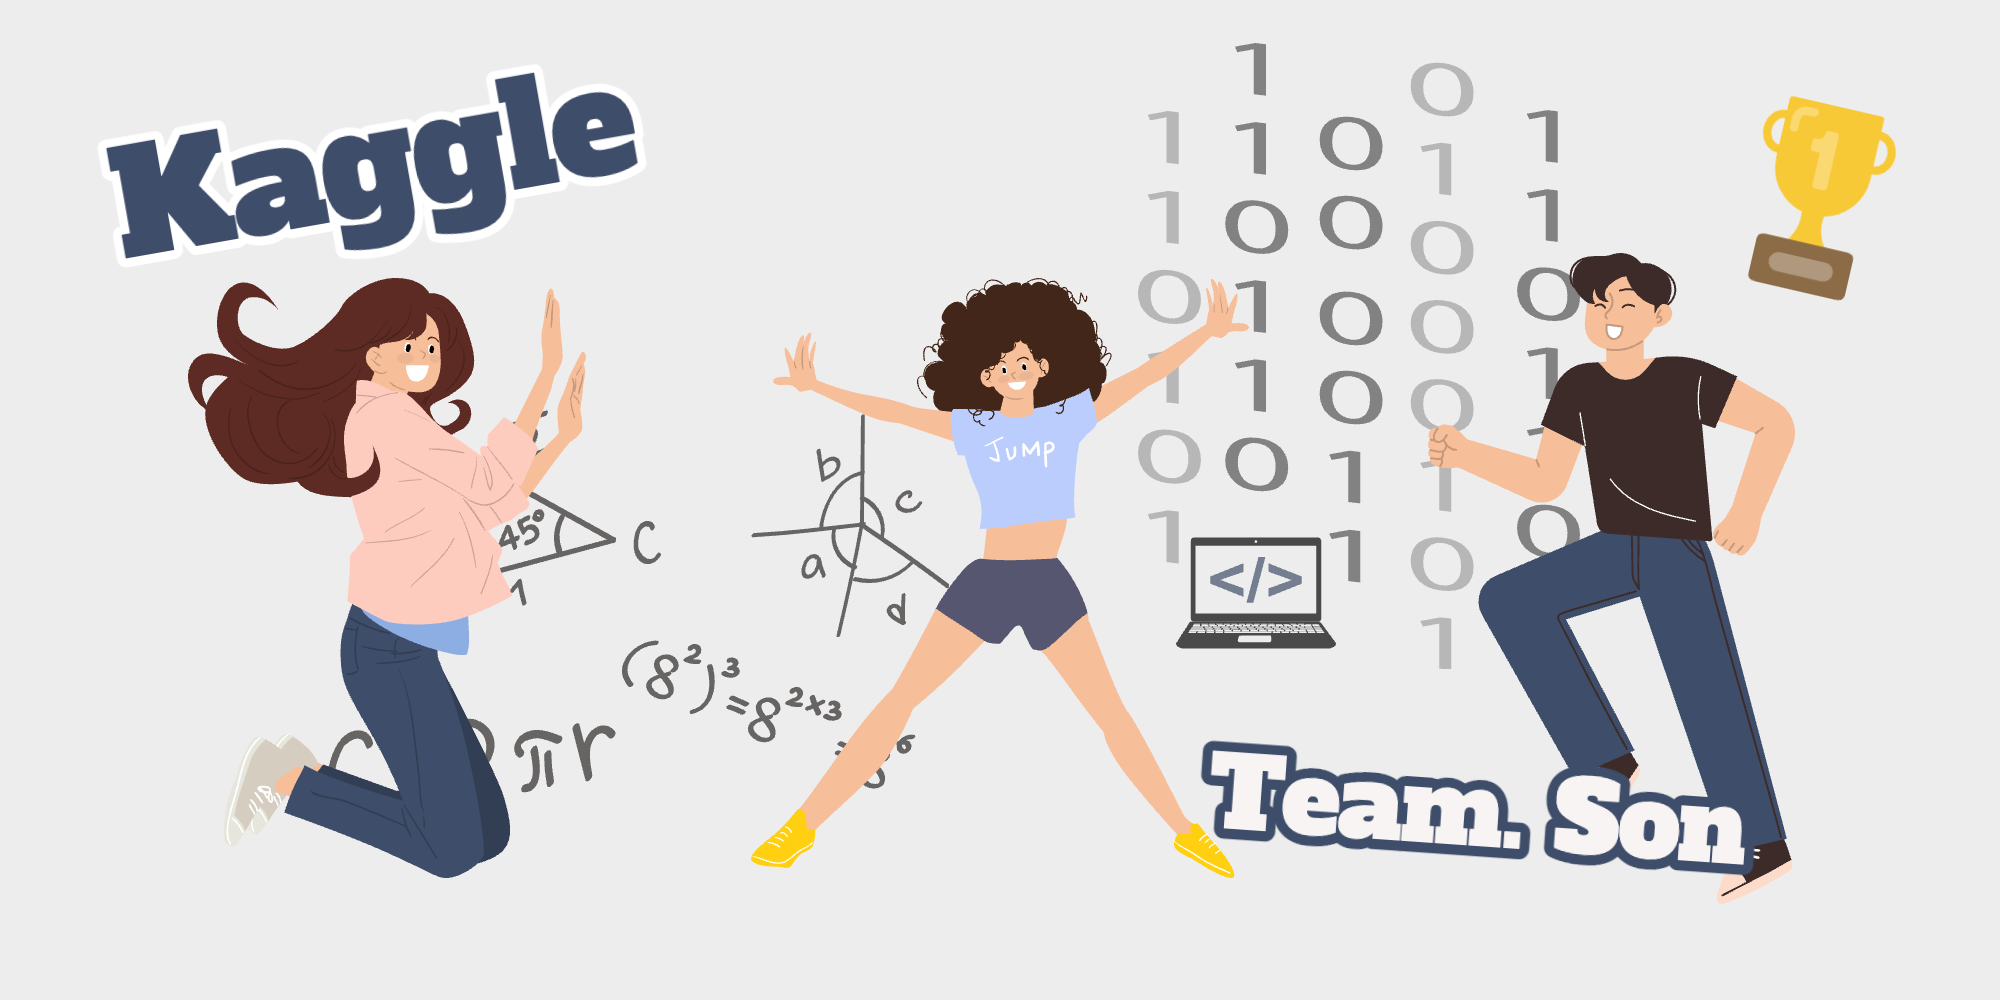

### **Data Description**

store_sales(in millions) - store_sales(in million dollars)  매장 매출액

unit_sales(in millions) - unit_sales(in millions) in stores Quantity  매장 내 판매 상품 수

Total_children - TOTAL CHILDREN IN HOME  해당 가구 내 총 아이의 수

avg_cars_at home(approx) - avg_cars_at home(approx)  해당 가구 내 차량 보유 대수

Num_children_at_home - num_children_at_home AS PER CUSTOMERS FILLED DETAILS  해당 고객이 세부사항에 명시한 가구 내 아이 수

Gross_weight - gross_weight OF ITEM  상품의 총 중량

Recyclable_package - FOOD ITEM IS recyclable_package  해당 상품이 재활용 가능한 포장재로 되어 있는지 여부

Low_fat - LOW_FAT FOOD ITEM IS LOW FAT  해당 상품이 저지방 제품인지 여부

Units_per_case - UNITS/CASE UNITS AVAILABLE IN EACH STORE SHELVES  각 상품 판매 단위의 수

Store_sqft - STORE AREA AVAILABLE IN SQFT  매장의 총 평방 피트

Coffee_bar - COFFEE BAR available in store  매장 내 커피 바 유무

Video_store - VIDEO STORE/gaming store available  매장 내 비디오 스토어/ 게임 판매 존 유무

Salad_bar - SALAD BAR available in store  매장 내 샐러드 바 유무

Prepared_food - food prepared available in store  매장 내 제조식품 유무

Florist - flower shelves available in store  매장 내 꽃 진열대 유무

Cost - COST ON ACQUIRING A CUSTOMERS in dollars  해당 고객을 확보하는데 드는 비용 (target data)


## **1. Import relevant libraries**

In [1]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Regressor
import xgboost
from xgboost import XGBRegressor

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Hyper Parameter Tuning
import optuna

# Data processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

## **2. Load files**

In [4]:
CFM_train_df = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
CFM_test_df = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')

## **3. Preview files**

In [5]:
"""Helper function to set dataframe presentation style."""

def set_frame_style(df, caption=""):
    
    return df.style.background_gradient(cmap='Oranges').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Orange'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

In [6]:
CFM_train_df.head(5)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [7]:
CFM_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [8]:
## DataFrame.nunique(axis=0, dropna=True) : 고유한 요소의 수를 구하는 메서드
cols = CFM_train_df.columns.to_list()
display(set_frame_style(CFM_train_df[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), 'Unique Value Counts In Each Column'))
display(set_frame_style(CFM_train_df[cols].isna().any().to_frame().transpose(), 'Columns With Nan'))

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
Unique Value Count,360336,1044,6,6,6,5,384,2,2,36,20,2,2,2,2,2,328


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
CFM_train_df.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


In [10]:
CFM_test_df.head(5)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [11]:
CFM_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240224 entries, 0 to 240223
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240224 non-null  int64  
 1   store_sales(in millions)    240224 non-null  float64
 2   unit_sales(in millions)     240224 non-null  float64
 3   total_children              240224 non-null  float64
 4   num_children_at_home        240224 non-null  float64
 5   avg_cars_at home(approx).1  240224 non-null  float64
 6   gross_weight                240224 non-null  float64
 7   recyclable_package          240224 non-null  float64
 8   low_fat                     240224 non-null  float64
 9   units_per_case              240224 non-null  float64
 10  store_sqft                  240224 non-null  float64
 11  coffee_bar                  240224 non-null  float64
 12  video_store                 240224 non-null  float64
 13  salad_bar     

In [12]:
cols = CFM_test_df.columns.to_list()
display(set_frame_style(CFM_test_df[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), 'Unique Value Counts In Each Column'))
display(set_frame_style(CFM_test_df[cols].isna().any().to_frame().transpose(), 'Columns With Nan'))

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
Unique Value Count,240224,1035,6,6,6,5,380,2,2,36,20,2,2,2,2,2


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### **SUMMARY** 

- **1 or 0 features**: recyclable_package, low_fat, coffee_bar, video_store, salad_bar, prepared_food, florist

- **Ordinal features**: unit_sales(in millions), total_children, num_children_at_home, avg_cars_at home(approx).1, units_per_case

- **Continuous features**: store_sales(in millions), gross_weight, store_sqft, cost

- No Nans to worry about

- Means and medians of continuous features are not too far off, so outliers are not that extreme


by KEENAN ZHUO (https://www.kaggle.com/code/keenanzhuo/ps3e11-basic-eda-regression-updated)

### **Curiosity** 

**(1) store_sales vs. unit_sales**

- Unit sales help determine the best price point for a product given the cost to manufacture.
- Unit sales are examined over different accounting periods, such as monthly, quarterly, or yearly.
- A company can forecast future unit sales by multiplying the anticipated number of units to be sold by the unit selling price.

👉🏼 Sales volume is defined as the number of units sold during a specific accounting period, such as per month, or per year.

👉🏼 The unit sales data on a balance sheet indicates the actual numbers of a product sold in a given reporting period. A company can forecast future and projected sales by multiplying the anticipated number of units to be sold by the unit selling price. Comparing unit sales over periods helps industry analysts determine if a company is moving in a positive direction.

(https://www.investopedia.com/terms/u/unitsales.asp)

**(2) Total_children vs. Num_children_at_home**

**(3) store_sqft**

👉🏼  In retail, sales per unit area is a standard and usually the primary measurement of store success.

👉🏼 unit_sales는 manufacture에 영향을 준다. 그리고 facilities 하나만 파생변수 만들고 xgboost돌렸을 때 store_sales 가 feature importances 1위 했다.


### **Results**

**(1) Adding Customized Columns**

상품 개수 대비 매출 = store_sales / unit_sales (오히려 결과 도출에 도움이 되지 않음)

평당 매출 = store_sales / store_sqft (오히려 결과 도출에 도움이 되지 않음) 

진열대 당 판매수량의 매출액 = store_sales / unit_sales / units_per_case (결과 도출에 상당히 좋은 영향을 줌)

**(2) Removing Unnecessary Columns**

id,cost (so far)

## **3. Rename Some of the Column Names**

In [13]:
CFM_train_df.rename(columns = {'store_sales(in millions)':'store_sales', 
                           'unit_sales(in millions)':'unit_sales',
                           'avg_cars_at home(approx).1':'avg_cars_at_home'}, inplace=True)
CFM_test_df.rename(columns = {'store_sales(in millions)':'store_sales', 
                           'unit_sales(in millions)':'unit_sales',
                           'avg_cars_at home(approx).1':'avg_cars_at_home'}, inplace=True)

## **4. Data exploration**

### **Correlation**

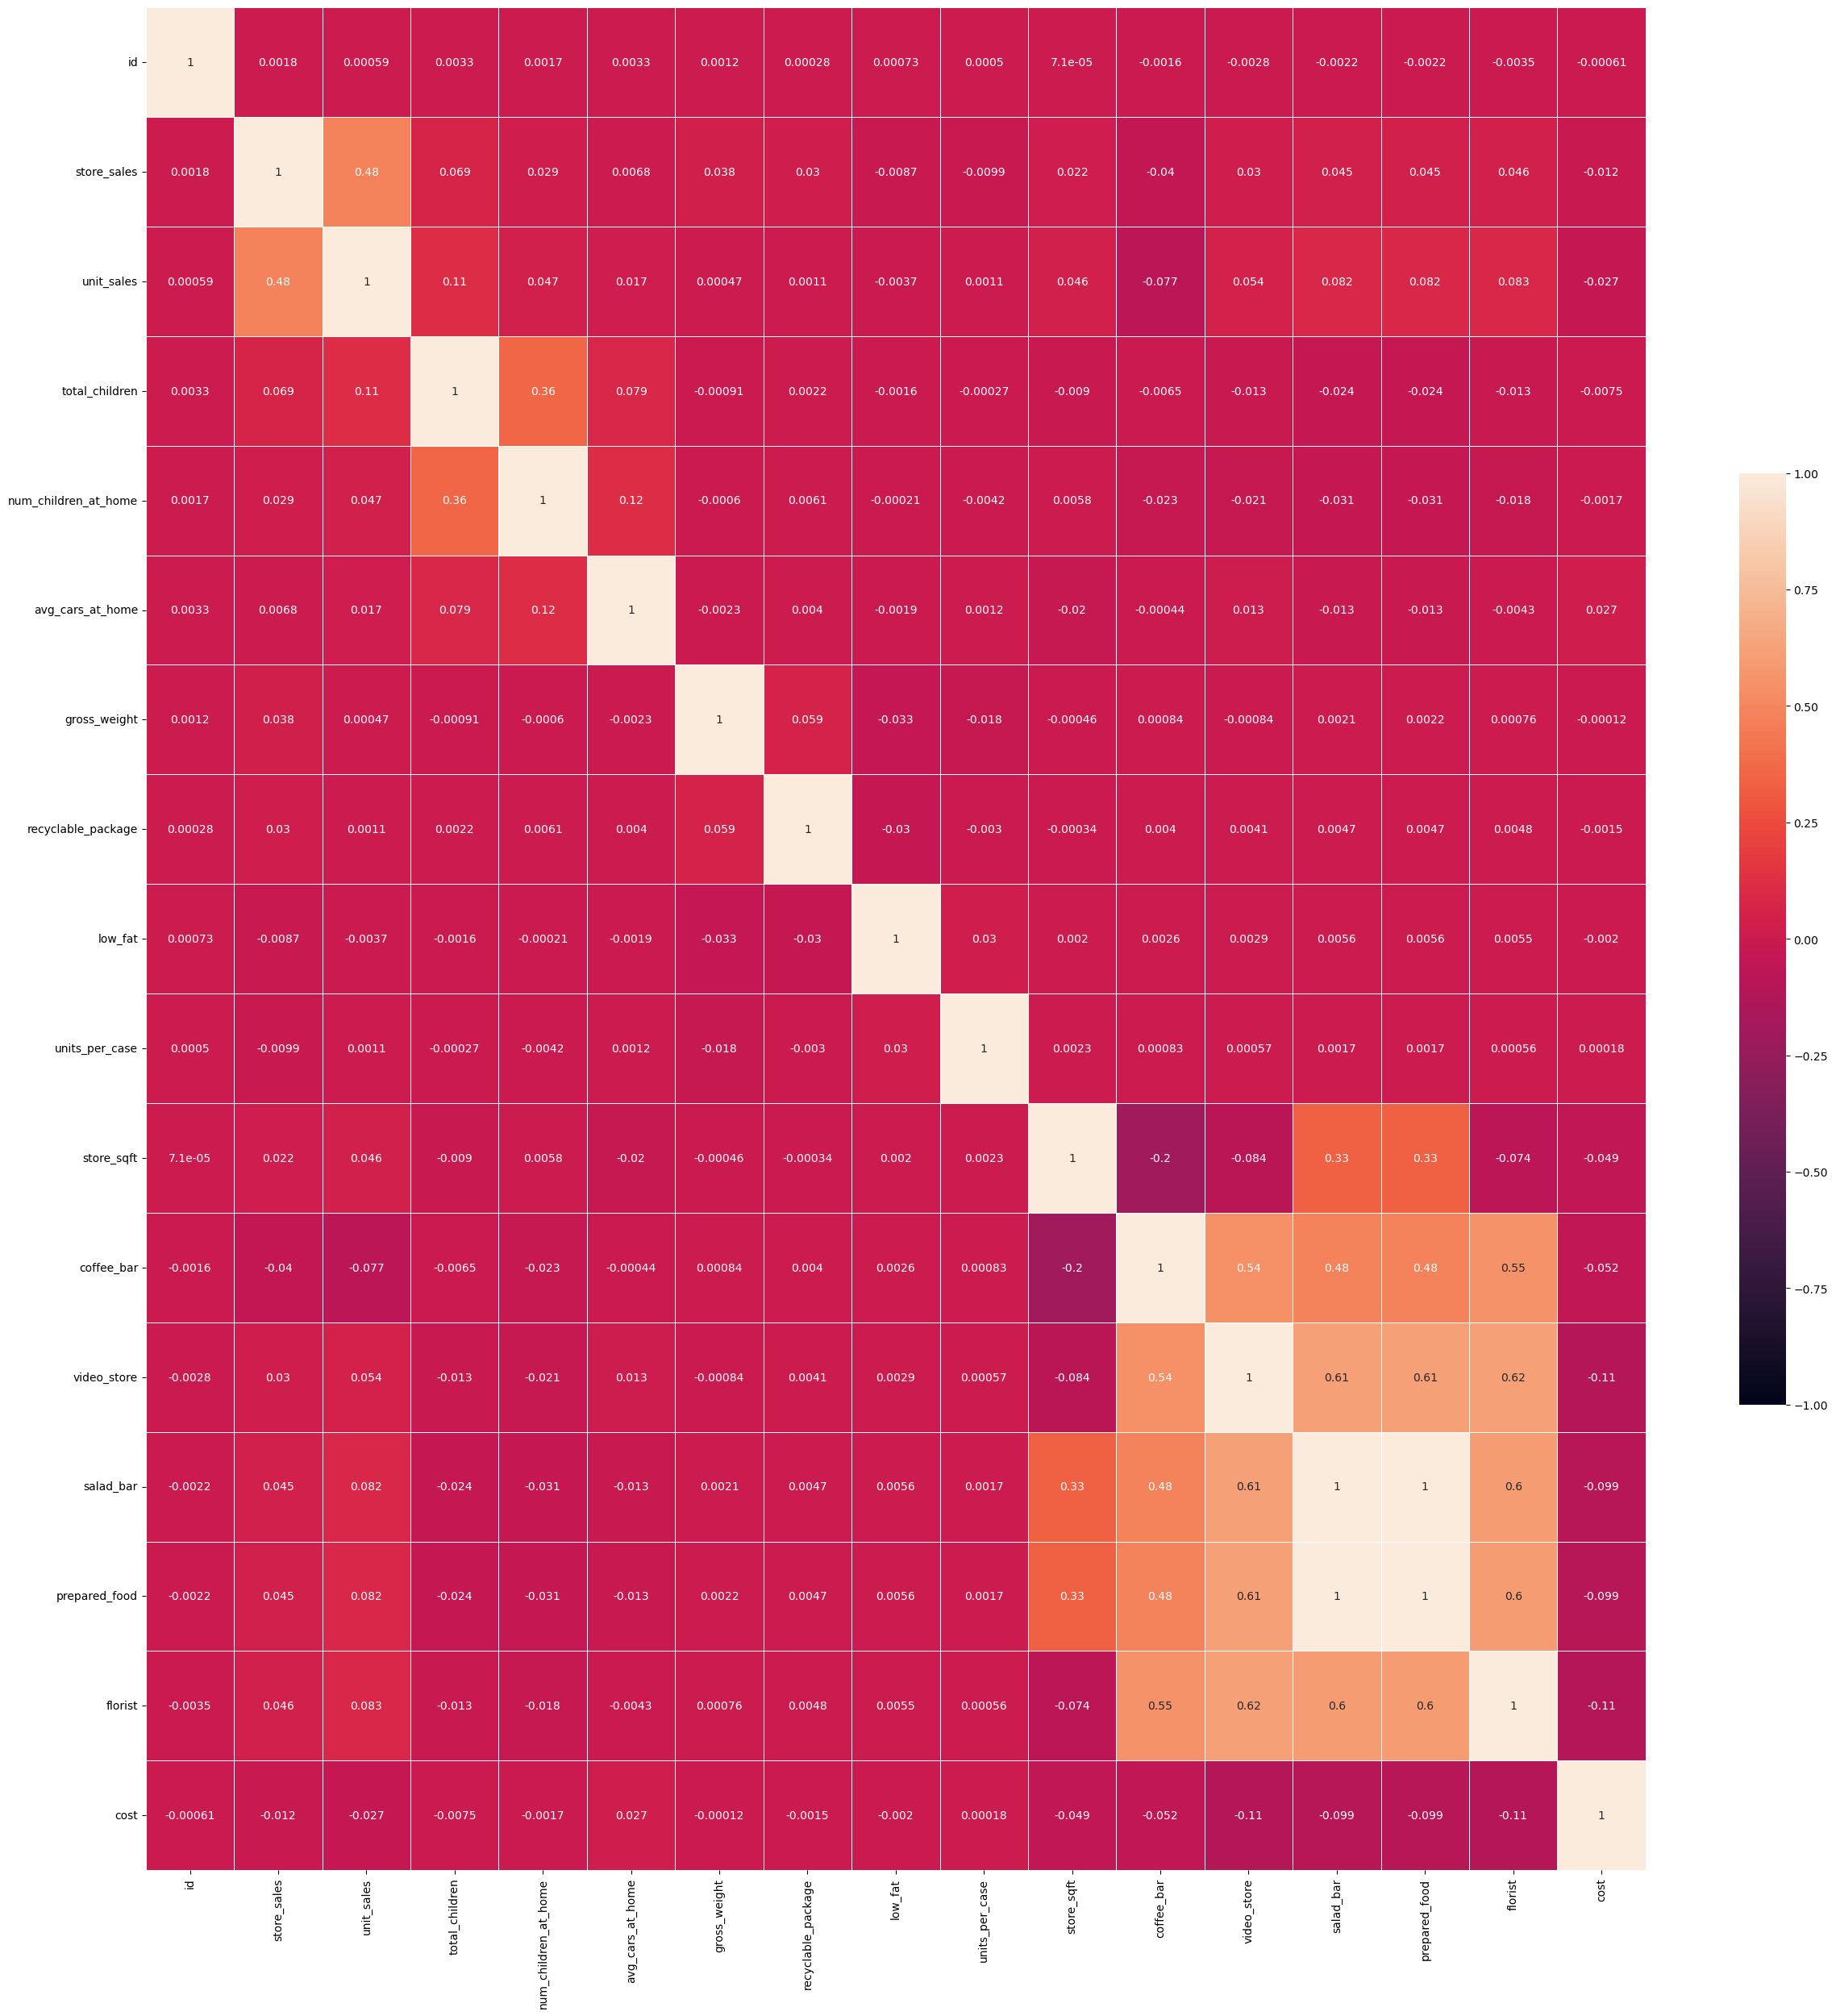

In [14]:
df = CFM_train_df.corr()

# 그림 사이즈 지정
plt.figure(figsize=(30,30))

# 히트맵을 그린다
sns.heatmap(df,  
            annot = True,   # 실제 값을 표시한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### **SUMMARY**

coffee_bar, video_game, florist, salad_bar, prepared_food 는 서로 상관관계가 있음

unit_sales, store_sales 역시 둘이 상관관계가 존재함

### **VIF**

독립변수는 독립성을 띄어야 함

In [15]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(CFM_train_df.loc[:, CFM_train_df.columns != 'cost'].values, i) for i in range(CFM_train_df.loc[:, CFM_train_df.columns != 'cost'].shape[1])]
vif["features"] = CFM_train_df.loc[:, CFM_train_df.columns != 'cost'].columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,6274.070159,salad_bar
1,6274.039686,prepared_food
2,19.411276,store_sqft
3,18.266985,unit_sales
4,8.832527,gross_weight
5,6.099940,store_sales
6,4.946853,avg_cars_at_home
7,4.265175,total_children
8,4.250426,units_per_case
9,4.111589,florist


### **SUMMARY**

상관관계와 다중공선성을 비교한 결과,

salad_bar와 prepared_food는 굉장히 높은 상관관계를 보이고 있으며 둘 중 하나는 제거 해야한다.

BUT! 

salad_bar, prepared_food, flourist, coffee_bar, video_store과 같은 시설은 서로서로 높은 상관관계를 보이고 있는 상황

따라서 5 곳을 편의시설로 묶을 수 있음 --> 비슷한 것 혹은 상관관계가 높은 컬럼들은 차원 축소하면서 전처리를 해줘야 함

해당 시설들을 편의시설로 묶어준 뒤, 매장 당 편의시설 개수에 따라 categorical number을 부여할 계획 
- 4개 이상 운영하면 1.0, 2개 이상 0.5, 0~1 개 운영 0)
- 편의시설이 많으면 많을 수록 손님 유치에 비용이 더 들어간다고 판단했기 때문이다. 


### **Overall Data**

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'store_sales'}>,
        <AxesSubplot:title={'center':'unit_sales'}>,
        <AxesSubplot:title={'center':'total_children'}>],
       [<AxesSubplot:title={'center':'num_children_at_home'}>,
        <AxesSubplot:title={'center':'avg_cars_at_home'}>,
        <AxesSubplot:title={'center':'gross_weight'}>,
        <AxesSubplot:title={'center':'recyclable_package'}>],
       [<AxesSubplot:title={'center':'low_fat'}>,
        <AxesSubplot:title={'center':'units_per_case'}>,
        <AxesSubplot:title={'center':'store_sqft'}>,
        <AxesSubplot:title={'center':'coffee_bar'}>],
       [<AxesSubplot:title={'center':'video_store'}>,
        <AxesSubplot:title={'center':'salad_bar'}>,
        <AxesSubplot:title={'center':'prepared_food'}>,
        <AxesSubplot:title={'center':'florist'}>],
       [<AxesSubplot:title={'center':'cost'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

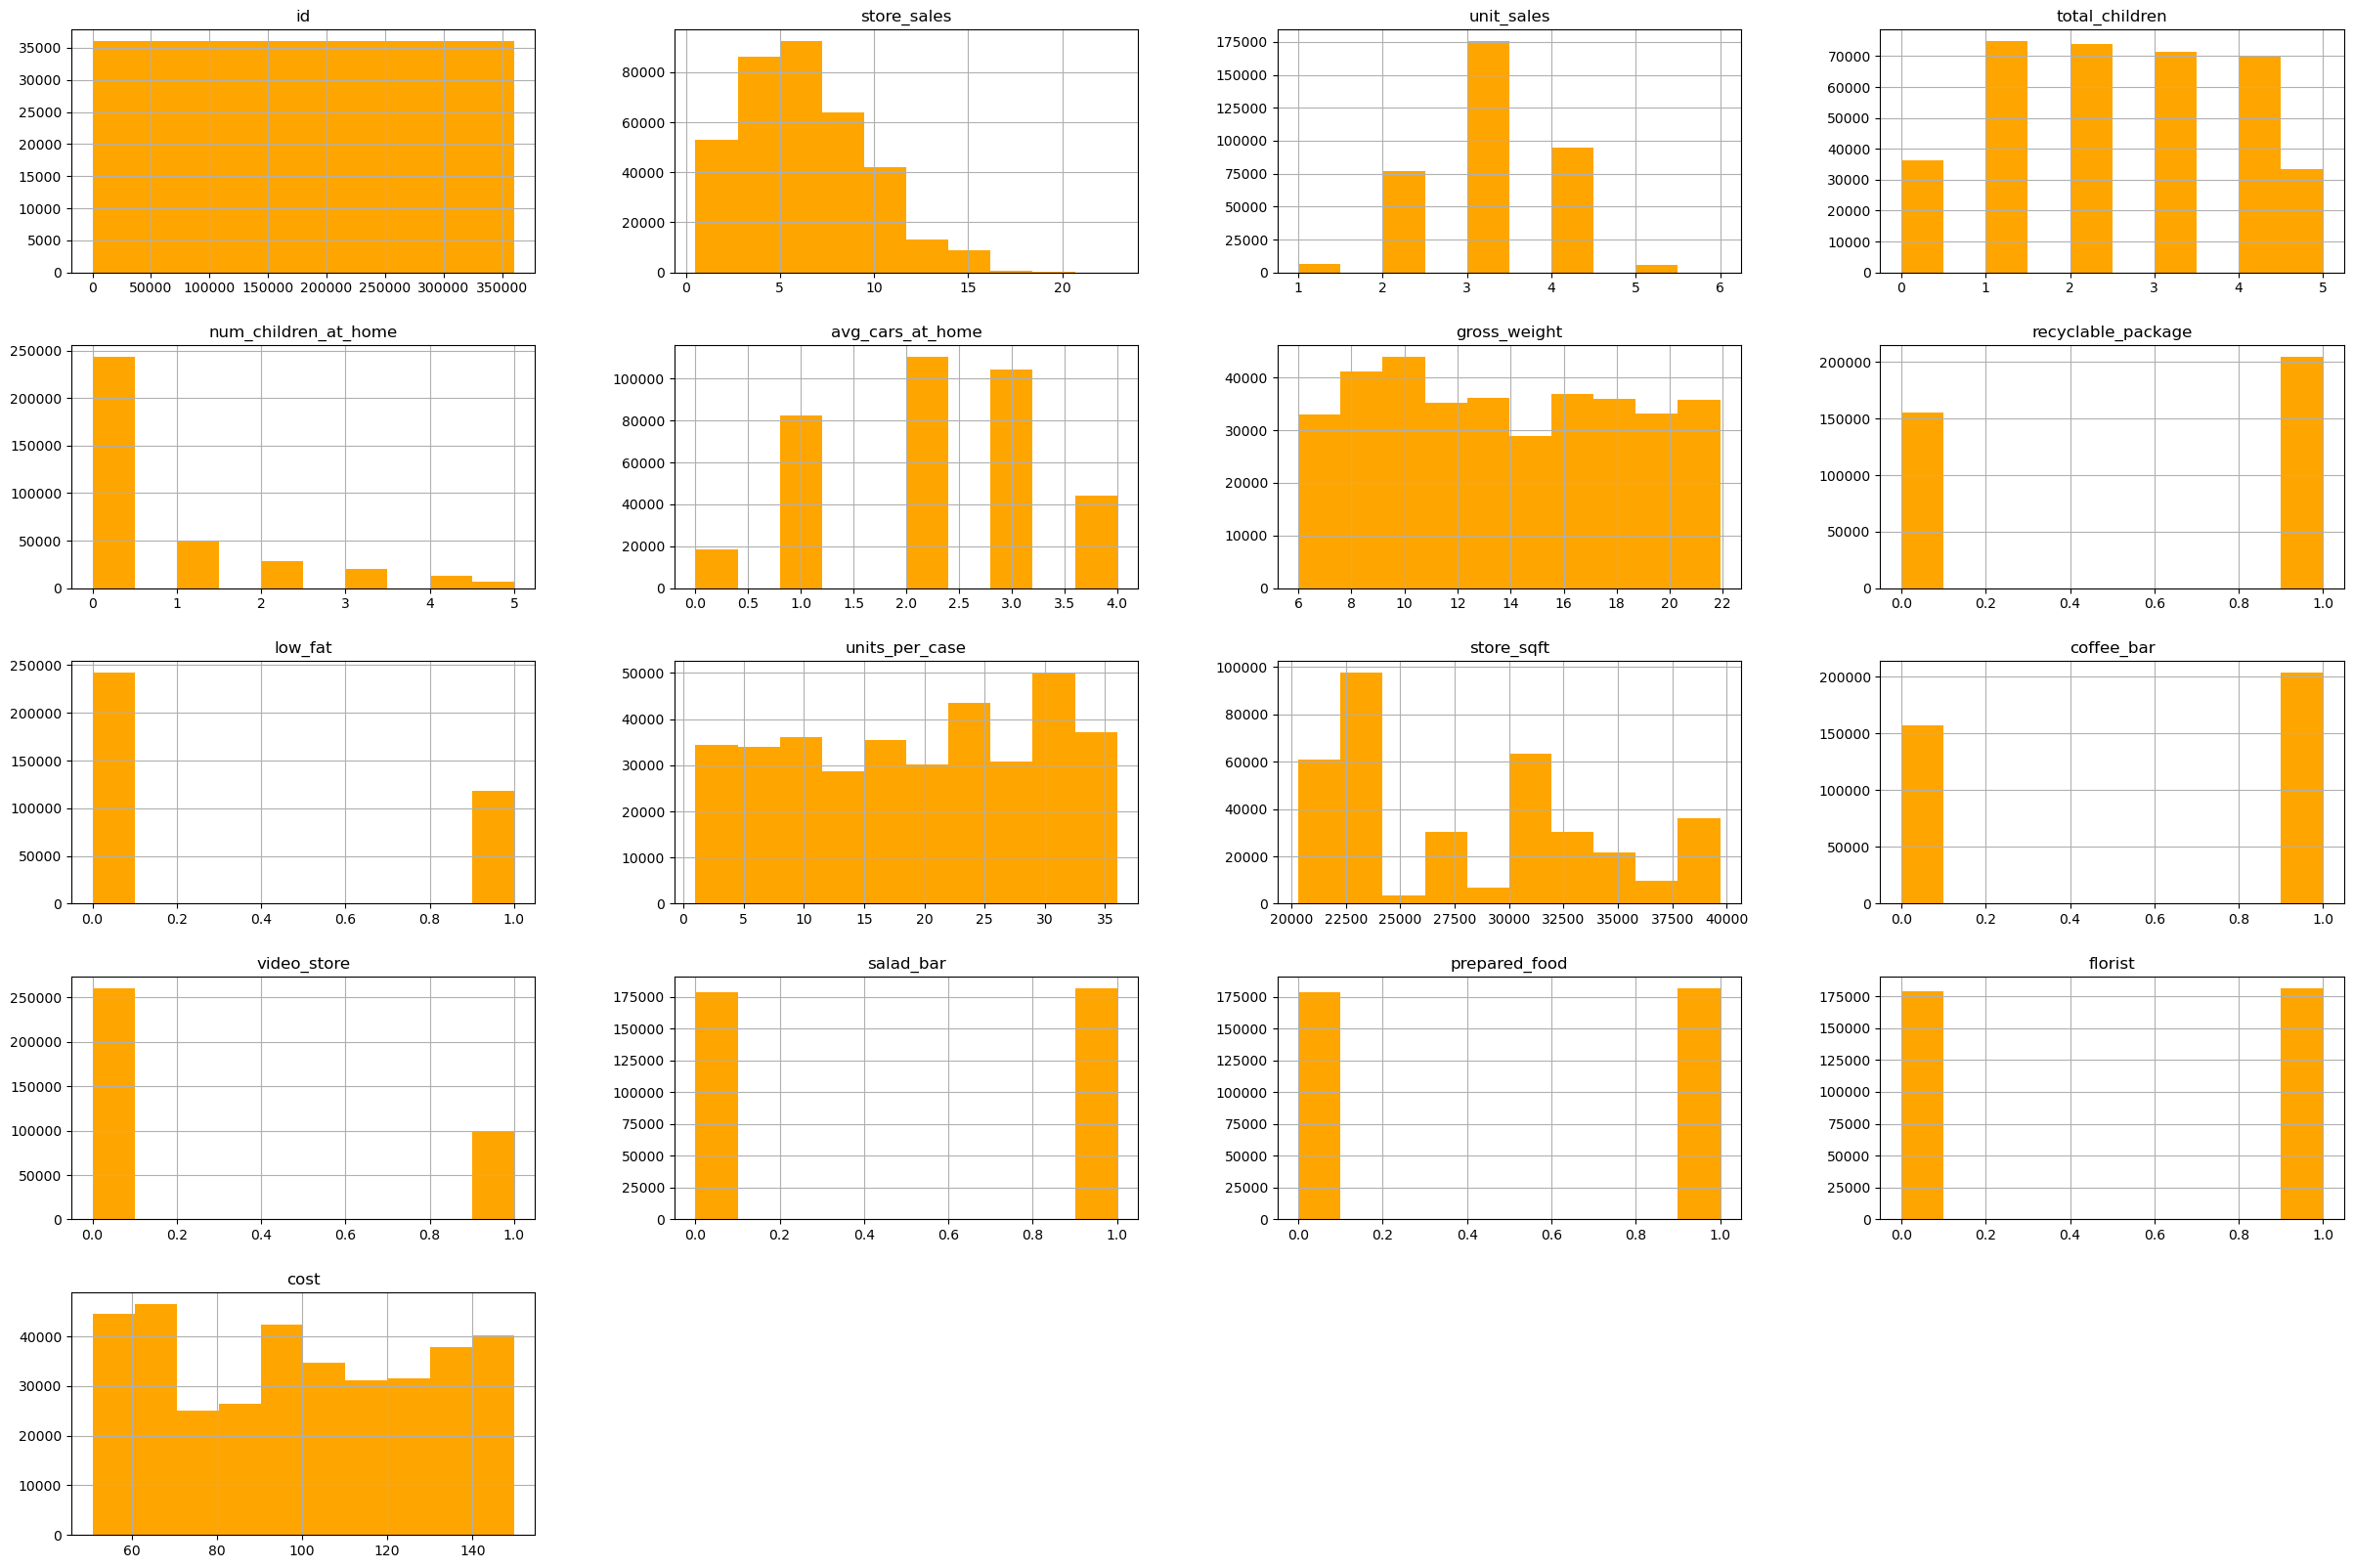

In [16]:
CFM_train_df.hist(figsize=(30,20),color='orange')

### **Continuous Data**

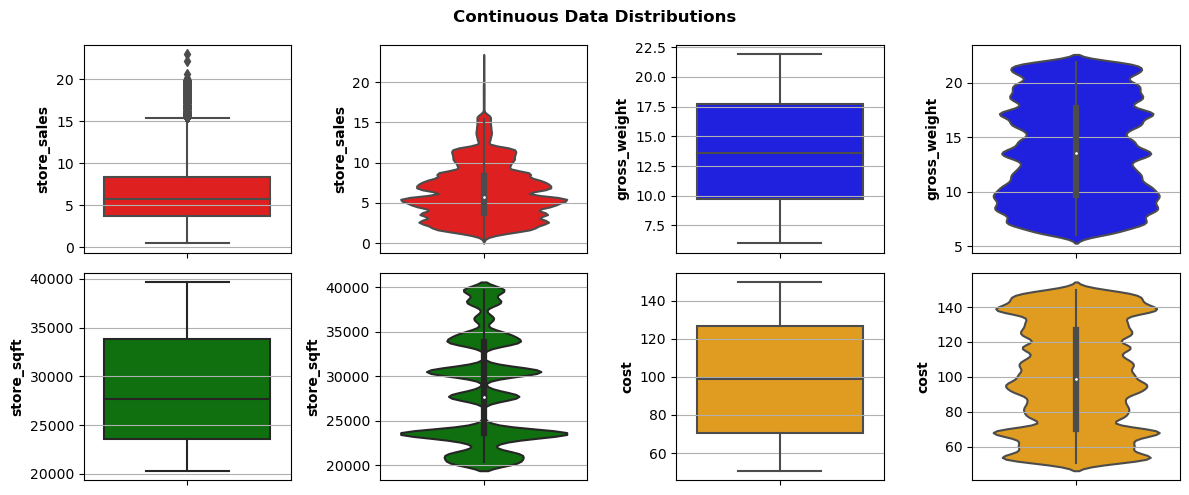

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,5))

row = 0
col = 0
crs = ['red', 'blue', 'green', 'orange']
for i, cc in enumerate(['store_sales', 'gross_weight', 'store_sqft', 'cost']):
    ax = sns.boxplot(data=CFM_train_df, y=cc, ax=axs[row, col], color=crs[i])
    ax.yaxis.grid()
    ax.set_ylabel(cc, weight='bold')
    
    ax = sns.violinplot(data=CFM_train_df, y=cc, ax=axs[row, col+1], color=crs[i])
    ax.yaxis.grid()
    ax.set_ylabel(cc, weight='bold')
    
    if col+1 == 3:
        col = 0
        row += 1
    else:
        col += 2
        
fig.suptitle('Continuous Data Distributions', weight='bold')
fig.tight_layout()
plt.show()

### **SUMMARY**

There are outliers in store_sales but it is okay because I am going to make some derived columns, using it

### **True/False Data**

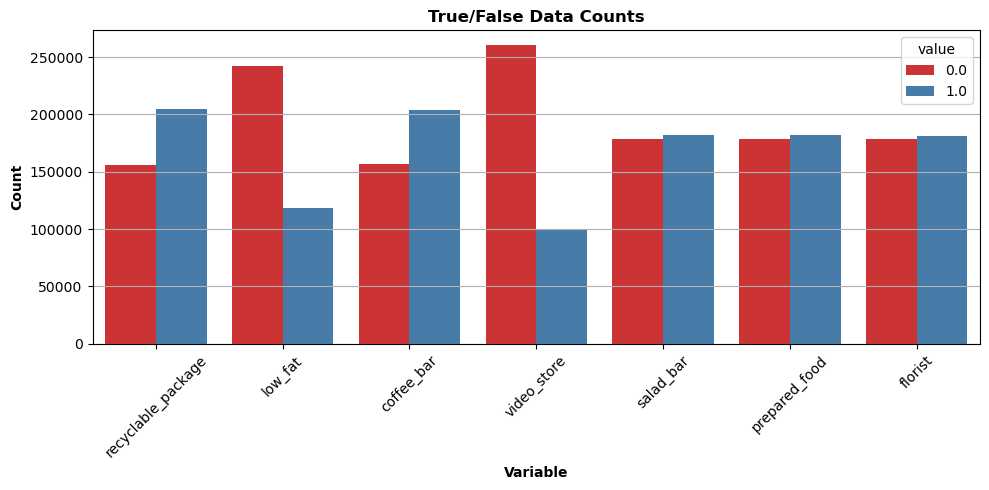

In [18]:
# Want to get counts for True/False features

# Start by melting a sub-dataframe for those features
dff = pd.melt(CFM_train_df, id_vars=['id'], value_vars=['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'])

plt.figure(figsize=(10,5))
cmap = sns.color_palette('Set1')

ax = sns.countplot(data=dff, x='variable', hue='value', palette=cmap)
ax.yaxis.grid()
ax.set_ylabel('Count', weight='bold')
ax.set_xlabel('Variable', weight='bold')    
ax.set_title('True/False Data Counts', weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### **Ordinal Data**

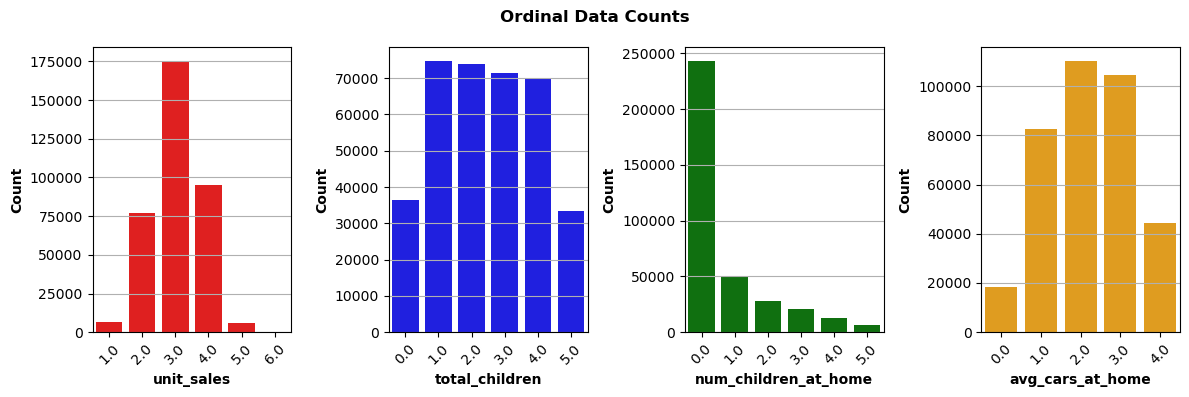

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

crs = ['red', 'blue', 'green', 'orange', 'purple']
for i, cc in enumerate(['unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home']):
    ax = sns.countplot(data=CFM_train_df, x=cc, ax=axs[i], color=crs[i])
    ax.yaxis.grid()
    ax.set_xlabel(cc, weight='bold')
    ax.set_ylabel('Count', weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
fig.suptitle('Ordinal Data Counts', weight='bold')
fig.tight_layout()
plt.show()

### **SUMMARY**

total_children 과 num_children 을 살펴보면 1,2,3,4,5 명일수록 count가 점점 감소하는 형태를 보여줌

또한 둘은 비슷한 의미를 담은 컬럼들이기 때문에 둘 중 하나만 사용하려고 하였지만 결합하는 방향으로 가보려고 함

그런데 이 둘을 곱하는게 좋을지 더하는게 좋을지 고민이 되긴하나 더하려고 함 

곱할 때 0값이 많이 나올 것 같기 때문

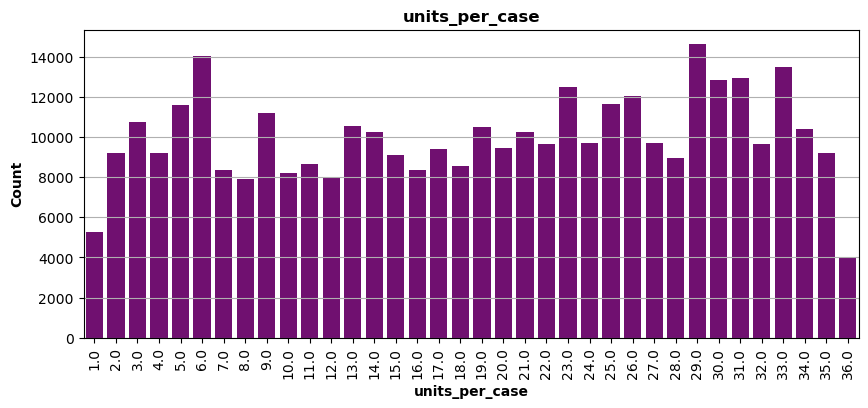

In [20]:
# Plot this apart from the other ordinal features because it has a lot more categories
plt.figure(figsize=(10,4))

ax = sns.countplot(data=CFM_train_df, x='units_per_case', color='purple')
ax.yaxis.grid()
ax.set_title('units_per_case', weight='bold')
ax.set_xlabel('units_per_case', weight='bold')
ax.set_ylabel('Count', weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

### **SUMMARY**

선형성을 띄고 있지 않은 상태

### **Cost Dependency On Features**

### **SUMMARY**

There are no cost dependency on features

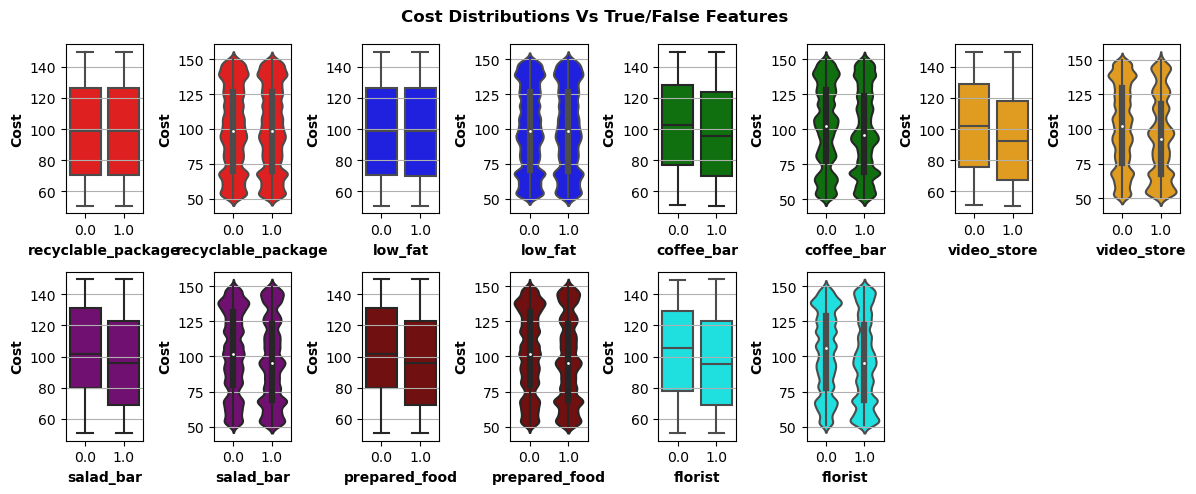

In [21]:
fig,axs = plt.subplots(nrows=2, ncols=8, figsize=(12,5))

row = 0
col = 0
crs = ['red', 'blue', 'green', 'orange', 'purple', 'maroon', 'cyan']
for i, cc in enumerate(['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']):
    ax = sns.boxplot(data=CFM_train_df, y='cost', x=cc, ax=axs[row, col], color=crs[i])
    ax.yaxis.grid()
    ax.set_xlabel(cc, weight='bold')
    ax.set_ylabel('Cost', weight='bold')
    
    ax = sns.violinplot(data=CFM_train_df, y='cost', x=cc, ax=axs[row, col+1], color=crs[i])
    ax.yaxis.grid()
    ax.set_xlabel(cc, weight='bold')
    ax.set_ylabel('Cost', weight='bold')
    
    if col+1 == 7:
        col = 0
        row += 1
    else:
        col += 2
        
fig.suptitle('Cost Distributions Vs True/False Features', weight='bold')
fig.delaxes(axs[1][7])
fig.delaxes(axs[1][6])
fig.tight_layout()
plt.show()

### **SUMMARY**

두 개씩 비슷한 양상을 띔

(recyclable - low, salad - prepared, florist - video)

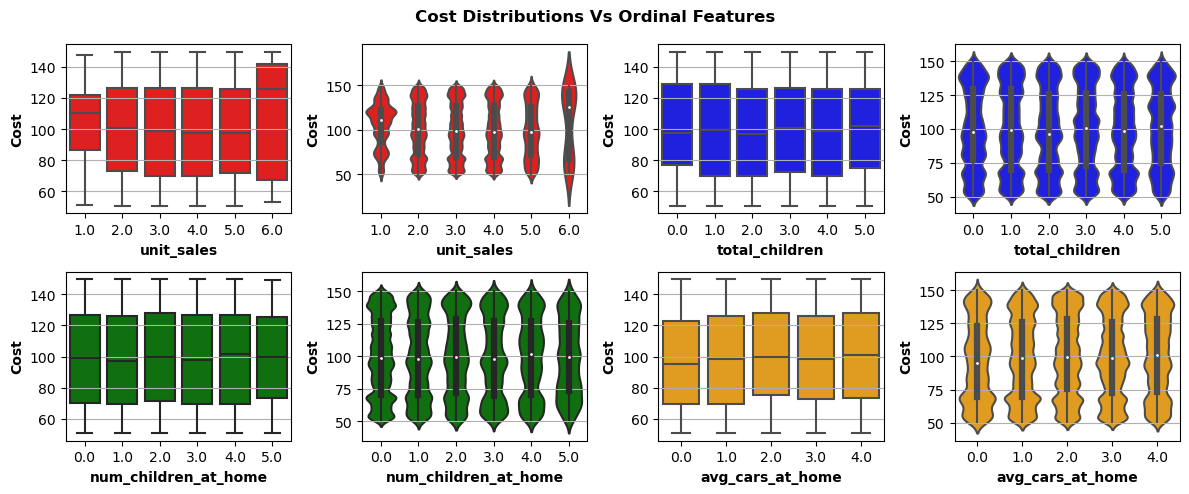

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,5))

row = 0
col = 0
crs = ['red', 'blue', 'green', 'orange', 'purple', 'maroon', 'cyan']
for i, cc in enumerate(['unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home']):
    ax = sns.boxplot(data=CFM_train_df, y='cost', x=cc, ax=axs[row, col], color=crs[i])
    ax.yaxis.grid()
    ax.set_xlabel(cc, weight='bold')
    ax.set_ylabel('Cost', weight='bold')
    
    ax = sns.violinplot(data=CFM_train_df, y='cost', x=cc, ax=axs[row, col+1], color=crs[i])
    ax.yaxis.grid()
    ax.set_xlabel(cc, weight='bold')
    ax.set_ylabel('Cost', weight='bold')
    
    if col+1 == 3:
        col = 0
        row += 1
    else:
        col += 2
        
fig.suptitle('Cost Distributions Vs Ordinal Features', weight='bold')
fig.tight_layout()
plt.show()

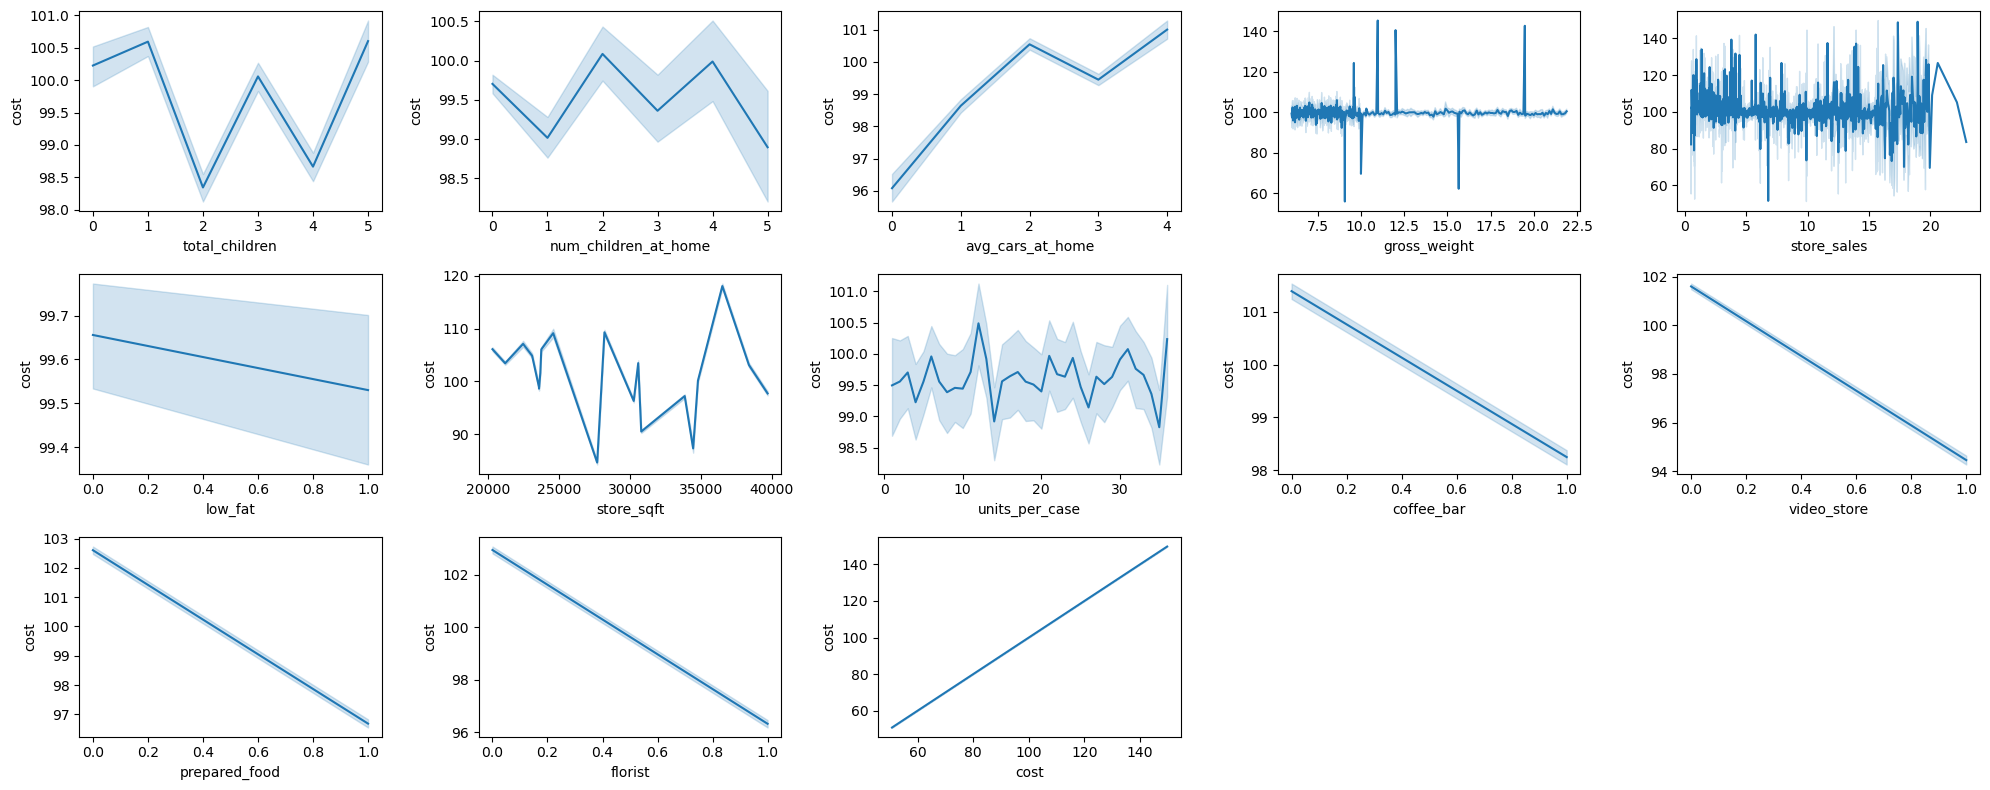

In [23]:
# 각 피처에 따른 비용 값에 대한 그래프

train_features = ['total_children','num_children_at_home','avg_cars_at_home','gross_weight',
                  'store_sales','low_fat','store_sqft','units_per_case',
                  'coffee_bar','video_store','prepared_food','florist','cost']
plt.figure(figsize = (20,8))
for i,feature in enumerate(train_features):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    sns.lineplot(x = CFM_train_df[feature],y = CFM_train_df['cost'])

### **SUMMARY**
total_children, num_children_at_home, store_sqft, (avg_cars_at_home)는 비선형성을 띄고 있다

avg_cars_at_home은 차량이 증가할 수록 상승하는 모습을 보여주기 때문에 인코딩을 진행하지는 않을 것

units_per_case 는 개수에 상관없이 가격이 바뀌니 원핫인코딩할 것 (한 후 결과값이 안했을 때 보다 안 좋아져서 안하기로 결정함)

## **5. Feature Engineering**


### **ASIS/TOBE**

😎 결론 서로 비슷하게 생긴 이산형 데이터들은 2 가지로 분리 

😎 unit_sales는 없애는 걸로, 따라서 unit_sales로 만들 수 있는 파생변수 만들기 --> revenue = store_sales/(unit_sales/units_per_case)

😎 total_children 과 num_children는 결합 (결합한 결과 결과 도출에 긍정적인 영향을 주지 않았으므로 제거)





**(1) Adding Customized Columns**

- 편의시설 = salad_bar + prepared_food + florist + coffee_bar + video_store

- 트렌드 = low_fat + recycle_packages

- 아이 수 = total_children + num_children_at_home

- revenue = store_sales/(unit_sales/units_per_case)

- store_sales 로그변환 (로그 변환한 후 평가지표가 좋아지지 않았기 때문에 하지 않기로 함)



**(2) Removing Unnecessary Columns**

- 'id','cost','salad_bar', 'prepared_food', 'coffee_bar', 'video_store', 'florist','total_children','num_children_at_home', 'store_sales','unit_sales'

In [24]:
train_scaled = copy.copy(CFM_train_df)
test_scaled = copy.copy(CFM_test_df)

In [25]:
train_scaled_y = train_scaled['cost']

### **Adding & Removing**

In [26]:
# (1) 편의시설 'facilities'
## 샐러드바, 커피 바 등 시설 병합 (4개 이상 운영하면 1.0, 2개 이상 0.5, 0~1 개 운영 0)

train_scaled['facilities'] = 0.0
test_scaled['facilities'] = 0.0

def check_variety(row):
    if row['coffee_bar'] + row['video_store'] + row['salad_bar'] + row['prepared_food'] + row['florist'] >= 4:
        return 1.0
    elif row['coffee_bar'] + row['video_store'] + row['salad_bar'] + row['prepared_food'] + row['florist'] >= 2:
        return 0.5
    else:
        return 0.0

train_scaled['facilities'] = train_scaled.apply(check_variety, axis=1)
test_scaled['facilities'] = test_scaled.apply(check_variety, axis=1)


# (1) 파생변수 및 필요없는 변수 삭제
train_scaled = train_scaled.drop(labels=['id','cost','salad_bar', 'prepared_food', 'coffee_bar', 'video_store', 'florist'],axis=1)
test_scaled = test_scaled.drop(labels=['id','salad_bar', 'prepared_food', 'coffee_bar', 'video_store', 'florist'],axis=1)

In [27]:
# # (2) trend = low_fat + recyclable_package 
train_scaled['trend'] = train_scaled['low_fat'] + train_scaled['recyclable_package']
test_scaled['trend'] = test_scaled['low_fat'] +  test_scaled['recyclable_package']

# # (2) 파생변수 및 필요없는 변수 삭제
train_scaled = train_scaled.drop(labels=['low_fat','recyclable_package'],axis=1)
test_scaled = test_scaled.drop(labels=['low_fat','recyclable_package'],axis=1)

In [28]:
# # (3) 판매가격 revenue = store_sales / unit_sales / units_per_case

train_scaled['revenue'] = 0.0
test_scaled['revenue'] = 0.0

def check_revenue(row):
    return row['store_sales'] / (row['unit_sales'] / row['units_per_case'])

train_scaled['revenue'] = train_scaled.apply(check_revenue, axis=1)
test_scaled['revenue'] = test_scaled.apply(check_revenue, axis=1)

# # # (3) 파생변수 및 필요없는 변수 삭제
train_scaled = train_scaled.drop(labels=['unit_sales','store_sales','units_per_case'],axis=1)
test_scaled = test_scaled.drop(labels=['unit_sales','store_sales','units_per_case'],axis=1)

## **Scaling**

In [29]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(train_scaled.loc[:, train_scaled.columns != 'cost'].values, i) for i in range(train_scaled.loc[:, train_scaled.columns != 'cost'].shape[1])]
vif["features"] = train_scaled.loc[:, train_scaled.columns != 'cost'].columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,11.820531,store_sqft
1,7.946002,gross_weight
2,4.708402,avg_cars_at_home
3,4.048269,total_children
4,2.746419,revenue
5,2.674745,trend
6,2.069152,facilities
7,1.530203,num_children_at_home


In [30]:
train_scaled.columns

Index(['total_children', 'num_children_at_home', 'avg_cars_at_home',
       'gross_weight', 'store_sqft', 'facilities', 'trend', 'revenue'],
      dtype='object')

In [31]:
MMS = MinMaxScaler()

for i in ['total_children', 'num_children_at_home', 'avg_cars_at_home',
       'gross_weight', 'store_sqft', 'facilities', 'trend', 'revenue']:
    MMS.fit(train_scaled[[i]])
    train_scaled[[i]] = MMS.transform(train_scaled[[i]])


In [32]:
MMS = MinMaxScaler()

for i in ['total_children', 'num_children_at_home', 'avg_cars_at_home',
       'gross_weight', 'store_sqft', 'facilities', 'trend', 'revenue']:
    MMS.fit(test_scaled[[i]])
    test_scaled[[i]] = MMS.transform(test_scaled[[i]])


### **Cost Scaling**

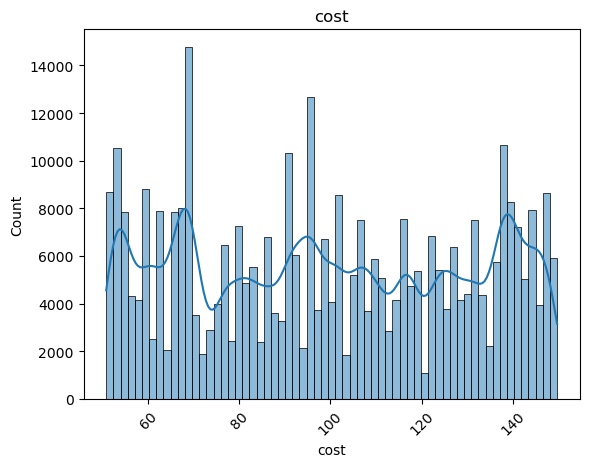

In [33]:
plt.title('cost')
plt.xticks(rotation=45)
sns.histplot(train_scaled_y,kde=True)
plt.show()

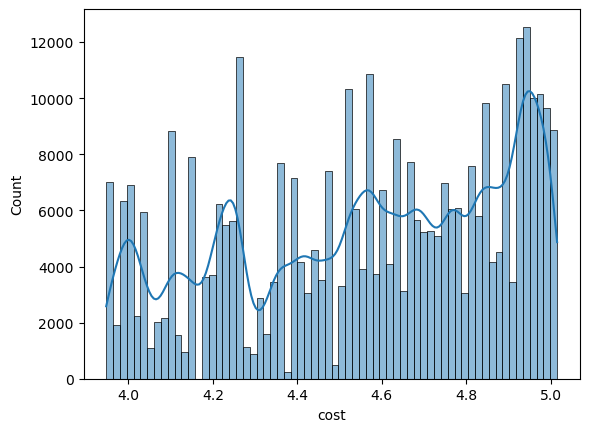

In [34]:
train_scaled_y = np.log1p(train_scaled_y)
sns.histplot(train_scaled_y,kde=True)
plt.show()

## **6. Evaluation**

In [35]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

## **7. Modeling**

### **XGBootRegressor**

In [36]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)
i =1
for train_index, test_index in fold.split(train_scaled):
    X_train, X_test = train_scaled.iloc[train_index], train_scaled.iloc[test_index]
    y_train, y_test = train_scaled_y.iloc[train_index], train_scaled_y.iloc[test_index]
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
    xgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300,verbose=100)
    preds = xgb_model.predict(X_test)
    print("rmsle : ", rmsle(np.expm1(y_test),np.expm1(preds)))

[0]	validation_0-rmse:3.75184	validation_1-rmse:3.75039
[100]	validation_0-rmse:0.29625	validation_1-rmse:0.29922
[200]	validation_0-rmse:0.29276	validation_1-rmse:0.29858
[300]	validation_0-rmse:0.29030	validation_1-rmse:0.29865
[400]	validation_0-rmse:0.28813	validation_1-rmse:0.29888
[500]	validation_0-rmse:0.28623	validation_1-rmse:0.29908
[531]	validation_0-rmse:0.28568	validation_1-rmse:0.29917
rmsle :  0.29853104997865065
[0]	validation_0-rmse:3.75128	validation_1-rmse:3.75285
[100]	validation_0-rmse:0.29669	validation_1-rmse:0.29777
[200]	validation_0-rmse:0.29349	validation_1-rmse:0.29738
[300]	validation_0-rmse:0.29093	validation_1-rmse:0.29726
[400]	validation_0-rmse:0.28866	validation_1-rmse:0.29739
[500]	validation_0-rmse:0.28669	validation_1-rmse:0.29760
[572]	validation_0-rmse:0.28531	validation_1-rmse:0.29779
rmsle :  0.29719350820103835
[0]	validation_0-rmse:3.75156	validation_1-rmse:3.75148
[100]	validation_0-rmse:0.29639	validation_1-rmse:0.29911
[200]	validation_0-r

## **8. Feature importances**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

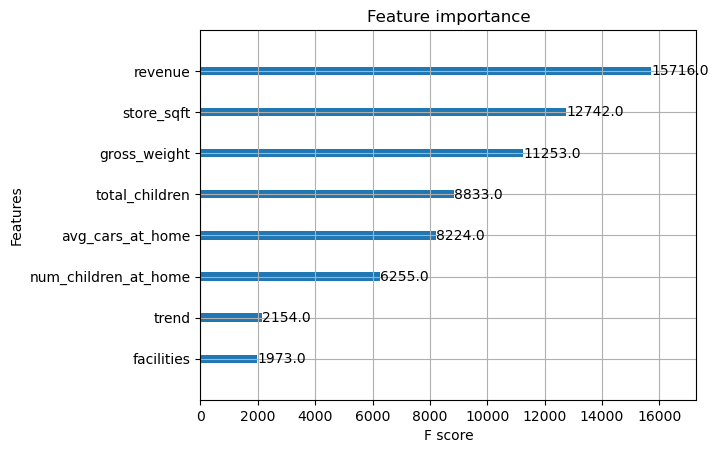

In [37]:
xgboost.plot_importance(xgb_model)

## **9.Hyperparameter Tuning**

In [38]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(train_scaled, train_scaled_y,test_size=0.2, random_state=156)

In [39]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return rmsle(y_test,y_pred)

In [40]:
print(y_test.shape)
print(X_test.shape)

(72068,)
(72068, 8)


In [41]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-04-04 06:28:37,459] A new study created in memory with name: regression
[I 2023-04-04 06:29:28,980] Trial 0 finished with value: 0.053984590359135845 and parameters: {'max_depth': 7, 'learning_rate': 0.3806878047312901, 'n_estimators': 359, 'min_child_weight': 9, 'gamma': 0.7926882640962918, 'subsample': 0.8930070140382669, 'colsample_bytree': 0.9192644817733603, 'reg_alpha': 0.12279437723947713, 'reg_lambda': 0.96264786700167, 'random_state': 211}. Best is trial 0 with value: 0.053984590359135845.
[I 2023-04-04 06:29:35,941] Trial 1 finished with value: 0.05609797211623284 and parameters: {'max_depth': 1, 'learning_rate': 0.43338248878222846, 'n_estimators': 283, 'min_child_weight': 9, 'gamma': 0.7840098437831345, 'subsample': 0.04859537066531508, 'colsample_bytree': 0.2704684177506745, 'reg_alpha': 0.8119868605770684, 'reg_lambda': 0.8740845377915941, 'random_state': 569}. Best is trial 0 with value: 0.053984590359135845.
[I 2023-04-04 06:30:33,210] Trial 2 finished with valu

In [42]:
# Print the best parameters
print('Best parameters', study.best_params)

Best parameters {'max_depth': 10, 'learning_rate': 0.5013712302120019, 'n_estimators': 181, 'min_child_weight': 9, 'gamma': 0.9970337930241138, 'subsample': 0.9845634492335206, 'colsample_bytree': 0.6957918320735142, 'reg_alpha': 0.14637047080556578, 'reg_lambda': 0.6284500606851999, 'random_state': 538}


In [43]:
# Print the best value
print('Best value', study.best_value)

Best value 0.05355116191141834


In [44]:
# Print the best trial
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=87, state=TrialState.COMPLETE, values=[0.05355116191141834], datetime_start=datetime.datetime(2023, 4, 4, 7, 52, 16, 392483), datetime_complete=datetime.datetime(2023, 4, 4, 7, 52, 47, 895305), params={'max_depth': 10, 'learning_rate': 0.5013712302120019, 'n_estimators': 181, 'min_child_weight': 9, 'gamma': 0.9970337930241138, 'subsample': 0.9845634492335206, 'colsample_bytree': 0.6957918320735142, 'reg_alpha': 0.14637047080556578, 'reg_lambda': 0.6284500606851999, 'random_state': 538}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False,

In [45]:
model = xgboost.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))
print('RMSE: ', np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred))))
print('RMSLE: ', rmsle(np.expm1(y_test),np.expm1(y_pred)))

MSE:  798.36295358131
RMSE:  28.255317262089093
RMSLE:  0.29439652763223056


## **10. Submission**

In [46]:
xgb_result = model.predict(test_scaled)
xgb_result = pd.DataFrame(np.expm1(xgb_result))
submission['cost'] = xgb_result

In [47]:
submission

,id,cost
0,360336,92.912384
1,360337,92.861786
2,360338,90.443726
3,360339,90.554497
4,360340,75.893768
...,...,...
240219,600555,98.153976
240220,600556,90.246841
240221,600557,90.759384
240222,600558,111.167587


In [48]:
xgb_result9_by_me = submission.to_csv('/kaggle/working/xgb_result9_by_me.csv', index=False)

In [49]:
xgb_result9_by_me = pd.read_csv('/kaggle/working/xgb_result9_by_me.csv')
xgb_result9_by_me

,id,cost
0,360336,92.912384
1,360337,92.861786
2,360338,90.443726
3,360339,90.554500
4,360340,75.893770
...,...,...
240219,600555,98.153980
240220,600556,90.246840
240221,600557,90.759384
240222,600558,111.167590


# **🌞 Thank You 🌞**

## **References**

- https://www.investopedia.com/terms/u/unitsales.asp (for the basic information of the dataset)
- https://www.kaggle.com/code/keenanzhuo/ps3e11-basic-eda-regression-updated  (for EDA)
- https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-xgboost  (for bayesian optimization)

## **Especially** 
#### 🤍 Son and Kim 🤍